In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

print(torch.version.cuda)
from datetime import datetime

9.2


In [193]:
n_cams = 16
image_size = 512
batch_size = 2
tex_size = 1024
sqr_size = 64

device = torch.device("cuda:0")
torch.cuda.set_device(device)

cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
cam_path = r'D:\CalibrationData\CameraCalibration\2019_12_13_Lada_Capture_k1k2k3p1p2\FinalCamParams\cam_params.json'
n_forwards = len(cams)
n_batch = int(n_forwards / batch_size)
print('n_forwards={}, batch_size={}, n_batch={}'.format(n_forwards, batch_size, n_batch))

#in_dir = './1_data/cow_mesh'
in_dir = './12_data'
mesh_path = in_dir + '/input/silhouette_fitted/vt_added/InterpolatedWithSparse.obj'

clean_plate_dir = r'D:\Pictures\2019_12_13_Lada_Capture\CleanPlates\undistorted'

n_forwards=16, batch_size=2, n_batch=8


In [133]:
def load_cameras(cam_path, device, actual_img_shape):
    print('actual_img_shape:',actual_img_shape)
    h = actual_img_shape[0]
    w = actual_img_shape[1]
    img_size = min(w, h)
    
    # load cameras
    cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

    with open(cam_path, 'r') as f:
        j = json.load(f)
        camera_params = j['cam_params']

    cam_params = []
    Rs, Ts, focal_lengths, principal_points = [], [], [], []
    for cam_idx, cam in enumerate(cams):
        cam_param = camera_params[str(cam_idx)]
        # for undistortion
        fx = cam_param['fx']
        fy = cam_param['fy']
        cx = cam_param['cx']
        cy = cam_param['cy']
        k1 = cam_param['k1']
        k2 = cam_param['k2']
        k3 = cam_param['k3']
        p1 = cam_param['p1']
        p2 = cam_param['p2']
        
        rvec = np.float32(cam_param['rvec'])
        T = np.float32(cam_param['tvec'])
        R, _ = cv2.Rodrigues(rvec)
        Rs.append(R.T)
        Ts.append(T)
        
        cx_corrected = cx*2/img_size - w/img_size
        cy_corrected = cy*2/img_size - h/img_size
        fx_corrected = fx*2/img_size
        fy_corrected = fy*2/img_size
        principal_point = np.array([cx_corrected, cy_corrected]).astype(np.float32)
        focal_length = np.array([fx_corrected, fy_corrected]).astype(np.float32)
        focal_lengths.append(focal_length)
        principal_points.append(principal_point)

        K = np.float32([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
        dist = np.float32([k1, k2, p1, p2, k3])
        cam_params.append({'K': K, 'dist': dist, 'R': R, 'T': T, 'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy})
    
    R_torch = torch.from_numpy(np.array(Rs).astype(np.float32))
    T_torch = torch.from_numpy(np.array(Ts).astype(np.float32))
    focal_length = torch.from_numpy(np.array(focal_lengths).astype(np.float32))
    principal_point = torch.from_numpy(np.array(principal_points).astype(np.float32))
    out_for_torch = {'R': R_torch, 'T': T_torch, 'fl': focal_length, 'pp': principal_point}
    return cam_params, out_for_torch

actual_img_shape = (2160, 4000)
cam_params, cams_torch = load_cameras(cam_path, device, actual_img_shape)
print(len(cam_params), ':', cam_params[0].keys())
print(cams_torch.keys())

def init_camera_batches(device, cam_torch, n_batch, batch_size):
    cams = []
    for batch_idx in range(n_batch):
        i0 = batch_idx*batch_size
        i1 = i0 + batch_size
        R = cam_torch['R'][i0:i1]
        T = cam_torch['T'][i0:i1]
        focal_length = cam_torch['fl'][i0:i1]
        principal_point = cam_torch['pp'][i0:i1]
        cameras = SfMPerspectiveCameras(device=device, R=R, T=T, principal_point=principal_point, focal_length=focal_length)
        cams.append(cameras)
    return cams

cam_batches = init_camera_batches(device, cams_torch, n_batch, batch_size)

actual_img_shape: (2160, 4000)
16 : dict_keys(['K', 'dist', 'R', 'T', 'fx', 'fy', 'cx', 'cy'])
dict_keys(['R', 'T', 'fl', 'pp'])


In [249]:
def load_clean_plates(img_dir, cam_params):
    img_paths = sorted(glob.glob(img_dir + '/*.PNG'))
    images0 = []
    images_undistort = []
    for i, path in enumerate(img_paths):
        # img = imageio.imread(path)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        images0.append(img)
        images_undistort.append(img)

    w = 2160 / 2
    clean_plates_cropped = []
    for i in range(len(images_undistort)):
        image = images_undistort[i]
        cx = image.shape[1] / 2

        image = images_undistort[i].astype(np.float32)
        img = image[:, int(cx-w):int(cx+w)]
        img = cv2.resize(img, (image_size, image_size))
        img = cv2.flip(img, -1)
        # img = np.dstack([img, img, img])
        clean_plates_cropped.append(img)
    
    return images0, images_undistort, clean_plates_cropped 

clean_plates_original, clean_plates_undistort, clean_plates = load_clean_plates(clean_plate_dir, cam_params)

# make clean_pates black
for i in range(len(clean_plates)):
    clean_plates[i] *= 0.0
print('clean_plates_original:', clean_plates_original[0].shape)

clean_plates_original: (2160, 4000)


In [250]:
# Rs = torch.empty((n_cams, 3, 3))
# Ts = torch.empty((n_cams, 3, ))

# cam_dist = 1500
# for i, theta in enumerate(np.arange(0, 360, 360/(n_cams))):
#     R, T = look_at_view_transform(cam_dist, 0, theta) 
#     Rs[i] = R
#     Ts[i] = T
    
# for i, ax in enumerate(np.arange(0, 360, 360/(n_cams/2))):
#     if ax % 90 == 0:
#         ax += 5
        
#     R, T = look_at_view_transform(cam_dist, ax, 0) 
#     Rs[i + int(n_cams/2)] = R
#     Ts[i + int(n_cams/2)] = T

# cameras = OpenGLPerspectiveCameras(device=device, R=Rs, T=Ts)


blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
raster_settings = RasterizationSettings(
    image_size=image_size, 
    blur_radius=0.0, #np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=1, 
)
lights = PointLights(device=device, location=((0.0, 0.0, 3000.0),))
a_diffuse = 0.0
a_ambient = 1.0
s = torch.from_numpy(np.zeros((1, 3)).astype(np.float32)).to(device)
d = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_diffuse).to(device)
a = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_ambient).to(device)
lights.specular_color = s
lights.diffuse_color = d
lights.ambient_color = a

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=None, raster_settings=raster_settings),
    shader=TexturedSoftPhongShader(device=device, blend_params=blend_params, lights=lights)
)

# Generate target images

torch.Size([1, 1024, 1024, 1])
1/8
2/8
3/8
4/8
5/8
6/8
7/8
8/8
(16, 512, 512)


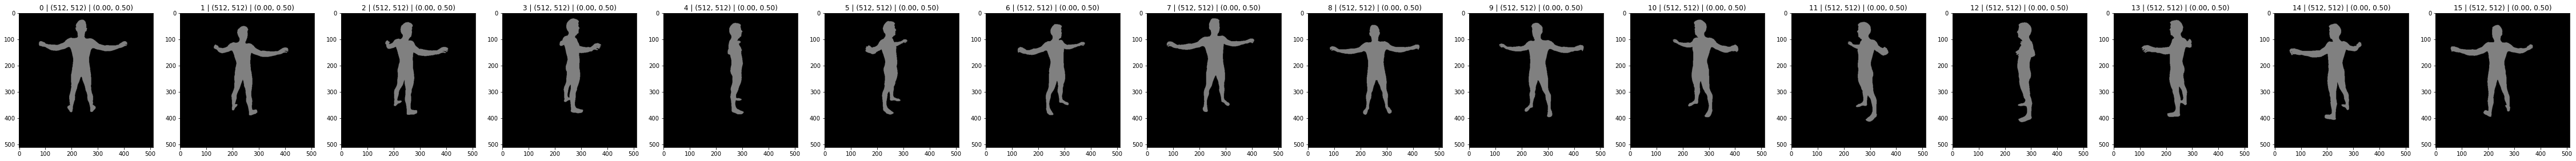

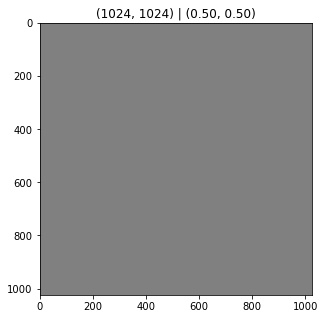

In [292]:
def load_mesh(device, mesh_path, texture_map, offset=np.zeros(3).astype(np.float32)):
    verts, faces, aux = load_obj(mesh_path)
    verts += offset
    faces_idx = faces.verts_idx

    verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
    faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)
    textures = Textures(maps=texture_map, faces_uvs=faces_uvs, verts_uvs=verts_uvs)

    mesh = Meshes(
        verts=[verts.to(device)],   
        faces=[faces_idx.to(device)], 
        textures=textures.to(device)
    )

    return mesh

def gen_target_texturemap(tex_size: int, sqr_size: int):
    tex = np.zeros((tex_size, tex_size)).astype(np.float32)
    
    n = int(tex_size / sqr_size)
        
    for r in range(n):
        r0 = r*sqr_size
        r1 = r0 + sqr_size
        i = r
        for c in range(n):
            c0 = c*sqr_size
            c1 = c0 + sqr_size
            if (i % 2) == 0:
                tex[r0:r1, c0:c1] = 0.0
            else:
                tex[r0:r1, c0:c1] = 1.0
            i += 1
    return torch.from_numpy(tex).unsqueeze(0).unsqueeze(-1)

def merge_fg_bg(fg, bg):
    """
    fg: mesh rendering. [N, W, H, 4]: [0, 1.0] float
    bg: clean plate. [N, W, H, 1]: [0, 1.0] float
    out: [N, W, H, 4]
    """
    out = torch.where(fg[..., 3] > 0.0, fg[..., 0], bg)
    # out = torch.mul(1-fg[..., 3], bg)
    if len(out.shape) < 3:
        out = out.unsqueeze(0)
    return out

def gen_target_images(device, mesh_path, texture_ref, offset, cam_batches, clean_plates, n_batch, batch_size):

    mesh_ref = load_mesh(device, mesh_path, texture_ref, offset=offset)
    # mesh_ref = load_mesh(device, mesh_path, texture_ref)

    bg = torch.from_numpy(np.float32(clean_plates)).to(device)
    
    # offset ref mesh
    image_refs = []
    for batch_idx in range(n_batch):
        i0 = batch_idx*batch_size
        i1 = i0 + batch_size
        print('{}/{}'.format(batch_idx+1, n_batch))
        meshes = mesh_ref.extend(batch_size)
        cam_batch = cam_batches[batch_idx]
        img_ref = renderer(meshes_world=meshes, cameras=cam_batch)
        img_ref = merge_fg_bg(img_ref, bg[i0:i1])
        image_refs.extend(img_ref.detach().cpu().numpy())
    image_refs = np.float32(image_refs)
    
    return image_refs

#texture_ref = imageio.imread(in_dir + '/cow_texture.png').astype(np.float32) / 255.0
# texture_ref = imageio.imread('./12_data/input/tex_gray.png').astype(np.float32) / 255.0
# texture_ref = torch.from_numpy(np.expand_dims(texture_ref, axis=0))
# texture_ref = gen_target_texturemap(tex_size, sqr_size)
texture_ref = torch.from_numpy(0.5*np.ones((tex_size, tex_size)).astype(np.float32)).unsqueeze(0).unsqueeze(-1)
print(texture_ref.shape)
offset = np.float32([100, 0, 0])
image_refs = gen_target_images(device, mesh_path, texture_ref, offset, cam_batches, clean_plates, n_batch, batch_size)
print(image_refs.shape)


fig, ax = plt.subplots(1, n_imgs, figsize=(5*n_imgs, 5))
for i in range(n_imgs):
    img = cv2.flip(image_refs[i], -1)
    ax[i].imshow(img, cmap='gray', vmin=0, vmax=1)
    ax[i].set_title('{} | {} | ({:.2f}, {:.2f})'.format(i, img.shape, np.min(img), np.max(img)))
plt.show()

plt.figure(figsize=(5, 5))
tex = texture_ref.squeeze().cpu().numpy()
plt.imshow(tex.squeeze(), cmap='gray', vmin=0, vmax=1)
plt.title('{} | ({:.2f}, {:.2f})'.format(tex.shape, np.min(tex), np.max(tex)))
plt.show()

# Model

In [293]:
class Model(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.device = params['device']
        self.image_size = params['image_size']
        self.batch_size = params['batch_size']
        self.n_batch = params['n_batch']
        self.renderer = params['renderer']
        self.mesh = params['mesh']
        self.image_refs = params['image_refs'].to(self.device)
        clean_plates = params['clean_plates']
        self.clean_plates = []
        for i in range(len(clean_plates)):
            self.clean_plates.append(clean_plates[i])
        self.clean_plates = torch.from_numpy(np.float32(self.clean_plates)).to(self.device)
        print('self.clean_plates:', self.clean_plates.shape)
        
        # cameras
        cams_torch = params['cams_torch']
        self.cam_batches = self._init_camera_batches(self.device, cams_torch, self.n_batch, self.batch_size)
        
        texture_map = params['texture_map']
        self.texture_map = nn.Parameter(texture_map.to(self.device), requires_grad=True)
        print('texture_map:', self.texture_map.shape)
        
        
    def forward(self, batch_idx):
        i0 = batch_idx*self.batch_size
        i1 = i0 + self.batch_size
        
        self.texture_map.requires_grad = True
        
        cam_batch = self.cam_batches[batch_idx]
        meshes = self.mesh.extend(self.batch_size)
        image_refs = self.image_refs[i0:i1]
        bgs = self.clean_plates[i0:i1]
        images = self.renderer(meshes_world=meshes, cameras=cam_batch, texture_maps=self.texture_map)
        image_cur_gray = self._merge_fg_bg(images, bgs)

        
        l_pixel = torch.mean((image_cur_gray - image_refs)**2)
#         l_pixel = torch.mean(torch.abs(images[..., :3] - image_refs))

#         l_reg = 0.1*torch.mean((0.5 - self.texture_map)**2)
        loss = l_pixel
        
        loss_dict = {'total': loss, 'pixel': l_pixel}
        image_dict = {'curr': image_cur_gray.clone().detach().squeeze().cpu().numpy(), 'ref': image_refs.clone().detach().squeeze().cpu().numpy()}
        
        return loss, loss_dict, image_dict
   
    def _merge_fg_bg(self, fg, bg):
        """
        fg: mesh rendering. [N, W, H, 4]: [0, 1.0] float
        bg: clean plate. [N, W, H, 1]: [0, 1.0] float
        out: [N, W, H, 4]
        """
        out = torch.where(fg[..., 3] > 0.0, fg[..., 0], bg)
        # out = torch.mul(1-fg[..., 3], bg)
        if len(out.shape) < 3:
            out = out.unsqueeze(0)
        return out
    
    def _init_camera_batches(self, device, cam_torch, n_batch, batch_size):
        cams = []
        for batch_idx in range(n_batch):
            i0 = batch_idx*batch_size
            i1 = i0 + batch_size
            R = cam_torch['R'][i0:i1]
            T = cam_torch['T'][i0:i1]
            focal_length = cam_torch['fl'][i0:i1]
            principal_point = cam_torch['pp'][i0:i1]
            cameras = SfMPerspectiveCameras(device=device, R=R, T=T, principal_point=principal_point, focal_length=focal_length)
            cams.append(cameras)
        return cams
    
texture_map = torch.zeros(texture_ref.shape).to(device)
mesh = load_mesh(device, mesh_path, texture_ref)
params = {
    'device': device,
    'mesh': mesh,
    'renderer': renderer,
    'texture_map': texture_map,
    'image_refs': torch.from_numpy(image_refs),
    'n_batch': n_batch,
    'batch_size': batch_size,
    'image_size': image_size,
    'cams_torch': cams_torch,
    'clean_plates': clean_plates
}
model = Model(params)

self.clean_plates: torch.Size([16, 512, 512])
texture_map: torch.Size([1, 1024, 1024, 1])


# Learn

In [288]:
def plot_curr(save_dir, e, lr, cam_idx, losses, images, texture_map):
    img_cur = cv2.flip(images['curr'][cam_idx], -1)
    img_ref = cv2.flip(images['ref'][cam_idx], -1)
    diff = img_cur - img_ref
    
    fig, ax = plt.subplots(1, 5, figsize=(25, 5), tight_layout=True)
    a_loss = ax[0]
    a_target = ax[1]
    a_curr = ax[2]
    a_diff = ax[3]
    a_tex = ax[4]
    
    legends = []
    for k, l in losses.items():
        legends.append(k)
        if k == 'total':
            a_loss.plot(l, linewidth=3)
        else:
            a_loss.plot(l)
    a_loss.legend(legends)
    a_loss.set_title('[{}] Loss\nlr={} | loss={}'.format(e, lr, losses['total'][-1]))
    a_loss.grid(True)
    
    a_curr.imshow(img_cur, cmap='gray', vmin=0, vmax=1)
    a_curr.set_title('Current cam={} | {} | ({:.2f}, {:.2f})'.format(cam_idx, img_cur.shape, np.min(img_cur), np.max(img_cur)))
    a_target.imshow(img_ref, cmap='gray', vmin=0, vmax=1)
    a_target.set_title('Target | {} | ({:.2f}, {:.2f})'.format(img_ref.shape, np.min(img_ref), np.max(img_ref)))
    a_diff.imshow(diff)
    a_diff.set_title('Difference | {} | ({:.6f}, {:.6f})'.format(diff.shape, np.min(diff), np.max(diff)))
    
    a_tex.imshow(texture_map, cmap='gray')
    a_tex.set_title('Texturemap | {} | ({:.6f}, {:.6f})'.format(texture_map.shape, np.min(texture_map), np.max(texture_map)))
    
    save_path = save_dir + '/plot_{}.png'.format(e)
    plt.savefig(save_path, dpi=150)
    plt.close('all')
    
    img = imageio.imread(save_path)
    return img

def plot_finals(save_dir, e, lr, losses, images, texture_map):
    img_cur = images['curr']
    img_ref = images['ref']
    diff = img_cur - img_ref
    
    n_row = len(img_cur)
    n_col = 3
    ig, ax = plt.subplots(1 + n_row, n_col, figsize=(n_col*5, (n_row+1)*5), tight_layout=True)
    
    ax[0, 1].axis(False)
    
    a_loss = ax[0, 0]
    legends = []
    for k, l in losses.items():
        legends.append(k)
        if k == 'total':
            a_loss.plot(l, linewidth=3)
        else:
            a_loss.plot(l)
    a_loss.legend(legends)
    a_loss.set_title('[{}] Loss\nlr={} | loss={}'.format(e, lr, losses['total'][-1]))
    a_loss.grid(True)
    
    a_tex = ax[0, 2]
    a_tex.imshow(texture_map, cmap='gray', vmin=np.min(texture_map), vmax=np.max(texture_map))
    a_tex.set_title('Texturemap | {} | ({:.6f}, {:.6f})'.format(texture_map.shape, np.min(texture_map), np.max(texture_map)))
    
    for r in range(n_row):
        a_ref = ax[r+1, 0]
        a_cur = ax[r+1, 1]
        a_diff = ax[r+1, 2]
        
        a_ref.imshow(cv2.flip(img_ref[r], -1), cmap='gray', vmin=0, vmax=1)
        a_ref.set_title('camera {}/{}'.format(r+1, n_row))
        a_cur.imshow(cv2.flip(img_cur[r], -1), cmap='gray', vmin=0, vmax=1)
        a_diff.imshow(cv2.flip(diff[r], -1))
        a_diff.set_xlabel('min={:.4f}, max={:.4f}'.format(np.min(diff[r]), np.max(diff[r])))
        if r == 0:
            a_ref.set_title('Target | {}'.format(img_ref[r].shape))
            a_cur.set_title('Current | {}'.format(img_cur[r].shape))
            a_diff.set_title('Difference')
    
    save_path = save_dir + '/plot_final_{}.png'.format(e)
    plt.savefig(save_path, dpi=150)
    plt.close('all')

    img = imageio.imread(save_path)
    return img

img = plot_finals(save_dir, e, lr_curr, losses, images_curr, texture_map.clone().detach().squeeze().cpu().numpy())
print('Done:', save_dir)

Done: ./12_data/output


# Train

self.clean_plates: torch.Size([16, 512, 512])
texture_map: torch.Size([1, 1024, 1024, 1])


<ipython-input-299-304a166c1ec6>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(1000000000))


Epoch     6: reducing learning rate of group 0 to 4.5000e-02.


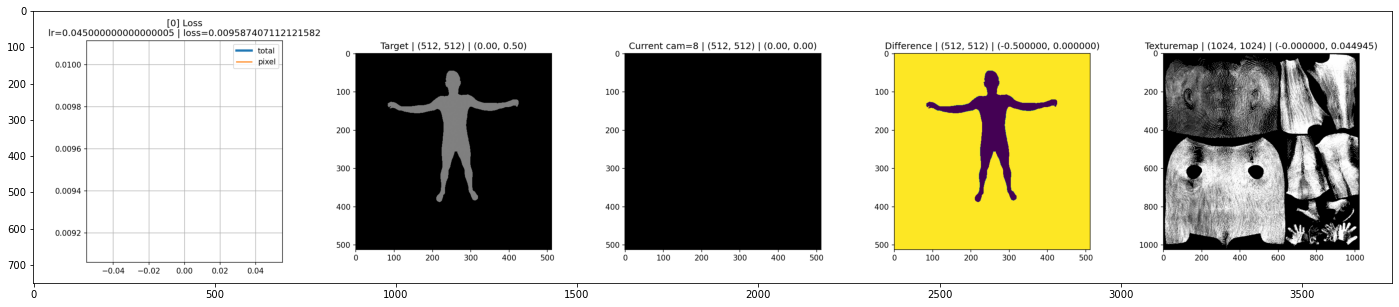

Epoch     9: reducing learning rate of group 0 to 4.0500e-02.
Epoch    14: reducing learning rate of group 0 to 3.6450e-02.
Epoch    17: reducing learning rate of group 0 to 3.2805e-02.
Epoch    22: reducing learning rate of group 0 to 2.9525e-02.
Epoch    25: reducing learning rate of group 0 to 2.6572e-02.
Epoch    30: reducing learning rate of group 0 to 2.3915e-02.
Epoch    33: reducing learning rate of group 0 to 2.1523e-02.
Epoch    38: reducing learning rate of group 0 to 1.9371e-02.
Epoch    41: reducing learning rate of group 0 to 1.7434e-02.
Epoch    46: reducing learning rate of group 0 to 1.5691e-02.
Epoch    49: reducing learning rate of group 0 to 1.4121e-02.
Epoch    54: reducing learning rate of group 0 to 1.2709e-02.
Epoch    57: reducing learning rate of group 0 to 1.1438e-02.
Epoch    62: reducing learning rate of group 0 to 1.0295e-02.
Epoch    65: reducing learning rate of group 0 to 9.2651e-03.
Epoch    70: reducing learning rate of group 0 to 8.3386e-03.
Epoch   

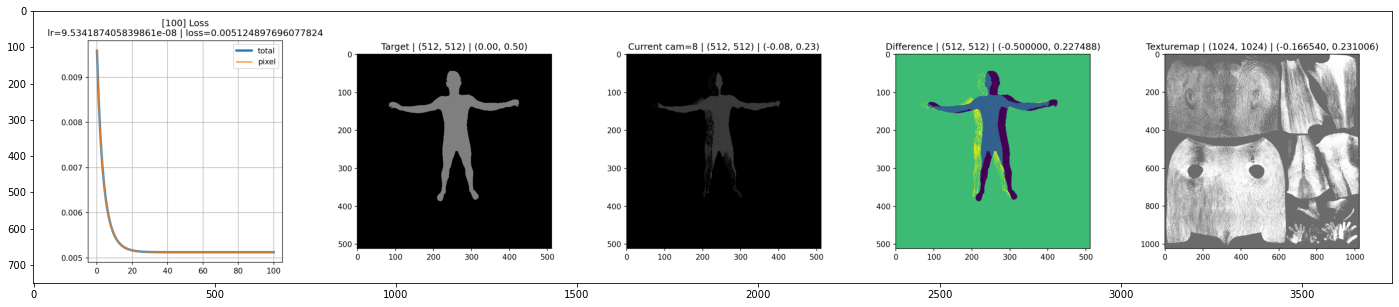

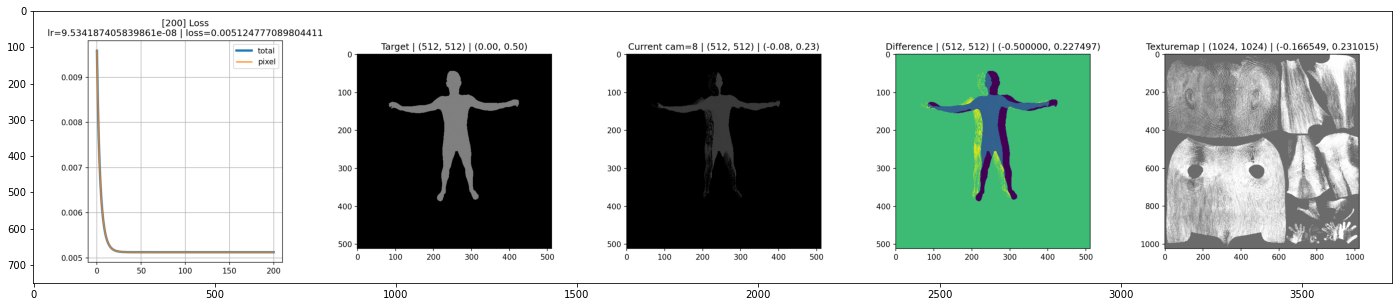

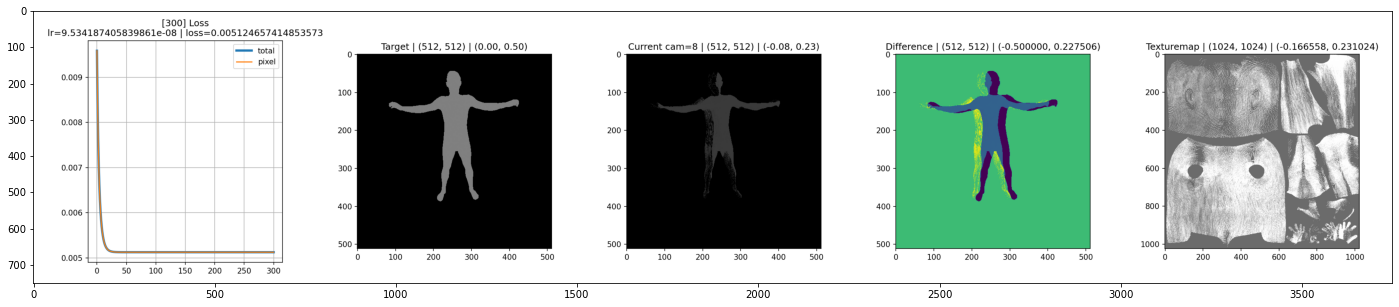

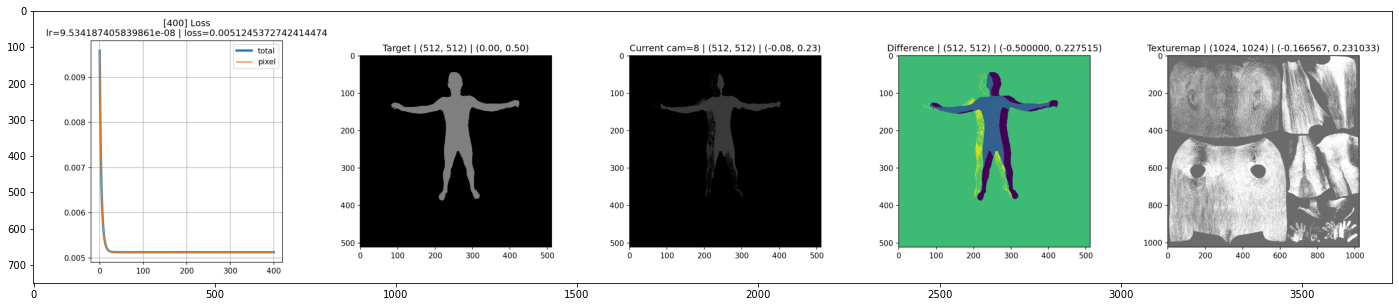

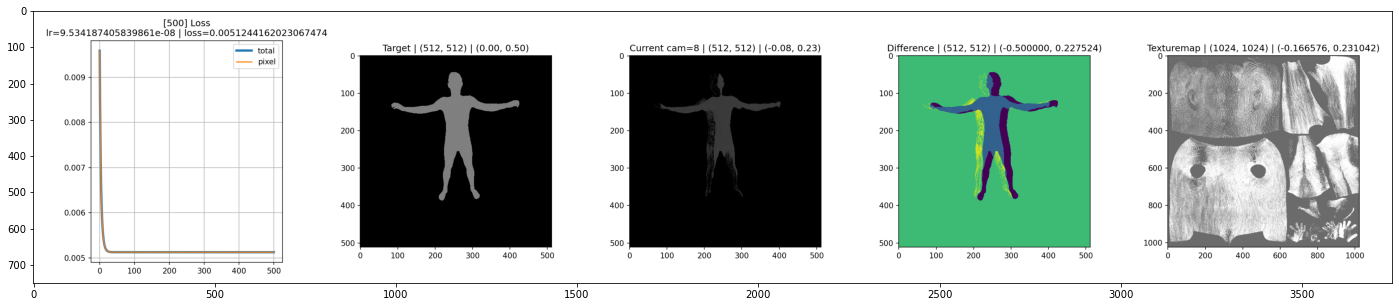

Done: 500


In [299]:
#texture_map = 0.5*torch.ones((1, tex_size, tex_size, 1)).to(device)
texture_map = 0.0*torch.ones((1, tex_size, tex_size, 1)).to(device)
mesh = load_mesh(device, mesh_path, texture_map)
params = {
    'device': device,
    'mesh': mesh,
    'renderer': renderer,
    'texture_map': texture_map,
    'image_refs': torch.from_numpy(image_refs),
    'n_batch': n_batch,
    'batch_size': batch_size,
    'image_size': image_size,
    'cams_torch': cams_torch,
    'clean_plates': clean_plates
}
model = Model(params)


save_dir = './12_data'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
save_dir += '/output'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
loop = tqdm_notebook(range(1000000000))
loop.set_description('start')

lr = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2, verbose=True)

    
cam_idx = 8
losses = {}
for e in loop:
    optimizer.zero_grad()
    
    losses_curr = {}
    images_curr = {}
    for batch_idx in range(n_batch):
        i0 = batch_idx*batch_size
        i1 = i0 + batch_size
        
        loss, l_dict, img_dict = model(batch_idx)
        
        loss.backward(retain_graph=True)
        scheduler.step(loss)
        
        for k, v in l_dict.items():
            if k not in losses_curr:
                losses_curr[k] = 0.0
                
            losses_curr[k] += v.data / (model.batch_size * model.n_batch)
            
        for k, v in img_dict.items():
            if k not in images_curr:
                images_curr[k] = []
            images_curr[k].append(v)
        
        lr_curr = optimizer.param_groups[0]['lr']
        loop.set_description('[{}] batch[{}/{}] lr={:.4f}, loss={:.6f}\n'.format(e, batch_idx+1, model.n_batch, lr_curr, l_dict['total']))
    optimizer.step()
    
    for k in images_curr.keys():
        img_cat = []
        for img in images_curr[k]:
            img_cat.append(img)
        images_curr[k] = np.vstack(img_cat)
        
    for k, v in losses_curr.items():
        if k not in losses:
            losses[k] = []
        losses[k].append(v)
        
    if e % 100 == 0:
        plot_img = plot_curr(save_dir, e, lr_curr, cam_idx, losses, images_curr, model.texture_map.clone().detach().squeeze().cpu().numpy())

        plt.figure(figsize=(25, 5))
        plt.imshow(plot_img)
        plt.show()
        
        texturemap_out = (255.0*np.clip(model.texture_map.detach().squeeze().cpu().numpy(), a_min=0, a_max=1.0)).astype(np.uint8)
        im = Image.fromarray(texturemap_out)
        im.save(save_dir + '/texture_map.png', dpi=(600, 600))
    if e == 500:
        plot_finals(save_dir, e, lr_curr, losses, images_curr, texture_map.detach().squeeze().cpu().numpy())
        break
print('Done:', e)           